# Three-level susceptibility & EIT

This example demonstrates damped Rabi flopping as calculated with the optical
Bloch equations for a three level system and calculates the three-level susceptibility
to demonstrate EIT.  It the first example with a three-manifold sytem, so we will focus on 
the construction of the Hamiltonian. 

State notation used within:
```
      ---- |e>



            ---- |r>
  ---- |g>

```
The three level detuning $\delta$ and two level detuning $\Delta$ are the standard detunings for a $\Lambda$ system.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

## Define the problem

### Hamiltonian

To construct the three-manifold Hamiltonian, we add the blocks to Hamiltonian one at a time.  The order in which they are added is important, as the manifolds are assumed to be in increasing energy order, even though their field-independent elements should already be placed in the appropriate rotating frames, implying that those elements should not contain optical-frequency components.

Our three manifold system is really quite simple, with each manifold containing a single state.  Detunings are placed on the $|r\rangle$ and $|e\rangle$ states.  Finally, the states are connected through $\pi$-polarized light.  We write a method to return the Hamiltonian given  the specified detunings.

In [2]:
Delta = -2; delta = 0.

H0 = np.array([[1.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0,] = 1/np.sqrt(2)

def return_three_level_hamiltonian(Delta, delta):
    hamiltonian = pylcp.hamiltonian()
    hamiltonian.add_H_0_block('g', 0.*H0)
    hamiltonian.add_H_0_block('r', delta*H0)
    hamiltonian.add_H_0_block('e', -Delta*H0)
    hamiltonian.add_d_q_block('g','e', d_q)
    hamiltonian.add_d_q_block('r','e', d_q)

    return hamiltonian

hamiltonian = return_three_level_hamiltonian(Delta, delta)
hamiltonian.print_structure()

[[(<g|H_0|g> 1x1) None (<g|d_q|e> 1x1)]
 [None (<r|H_0|r> 1x1) (<r|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) (<e|d_q|r> 1x1) (<e|H_0|e> 1x1)]]


### Lasers and magnetic fields

Here, a method returns the lasers for a given intensity.  Note that function returns a dictionary of two lasers, one addressing the $|g\rangle \rightarrow |e\rangle$ transition and the other the $|r\rangle \rightarrow |e\rangle$ transition.  Finally, we assume a constant zero magnitude magnetic field.

In [3]:
# First, define the lasers (functionalized for later):
Ige = 4; Ire = 4;
def return_three_level_lasers(Ige, Ire):
    laserBeams = {}
    laserBeams['g->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ige}],
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    laserBeams['r->e'] = pylcp.laserBeams(
        [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
          'pol_coord':'spherical', 'delta':0., 'beta':Ire}],                           
        beam_type=pylcp.infinitePlaneWaveBeam
    )
    return laserBeams

laserBeams = return_three_level_lasers(Ige, Ire)

# Second, magnetic field:
magField = lambda R: np.zeros(R.shape)

## Damped Rabi oscillations

We first evolve the optical Bloch equations to see damped Rabi oscillations in the three-level system.

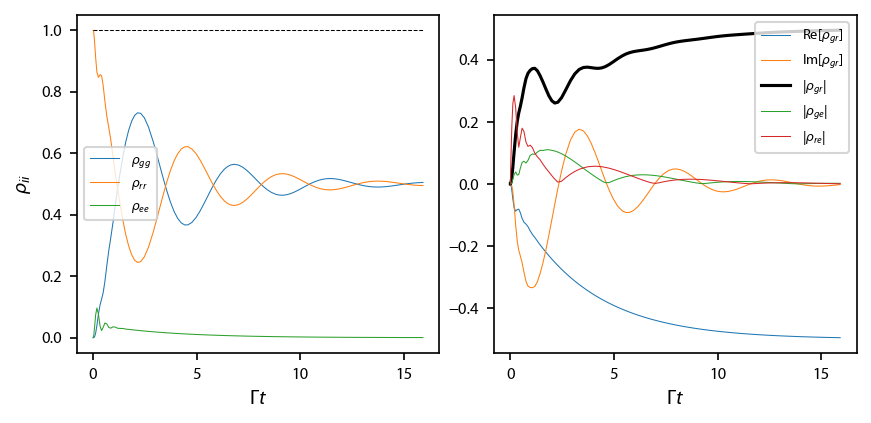

In [4]:
obe = pylcp.obe(laserBeams, magField, hamiltonian,
                transform_into_re_im=True)
obe.set_initial_rho_from_populations(np.array([0., 1., 0.]))
obe.evolve_density([0, 100])

fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 0]), linewidth=0.5, label='$\\rho_{gg}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[1, 1]), linewidth=0.5, label='$\\rho_{rr}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[2, 2]), linewidth=0.5, label='$\\rho_{ee}$')
ax[0].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 0]+obe.sol.rho[1, 1]+obe.sol.rho[2, 2]), 'k--', linewidth=0.5)
ax[0].legend(fontsize=7)
ax[0].set_xlabel('$\Gamma t$')
ax[0].set_ylabel('$\\rho_{ii}$')

ax[1].plot(obe.sol.t/2/np.pi, np.real(obe.sol.rho[0, 1]), linewidth=0.5,
           label='Re$[\\rho_{gr}]$')
ax[1].plot(obe.sol.t/2/np.pi, np.imag(obe.sol.rho[0, 1]), linewidth=0.5,
           label='Im$[\\rho_{gr}]$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 1]), 'k-',
           label='$|\\rho_{gr}|$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[0, 2]), linewidth=0.5, label='$|\\rho_{ge}|$')
ax[1].plot(obe.sol.t/2/np.pi, np.abs(obe.sol.rho[1, 2]), linewidth=0.5, label='$|\\rho_{re}|$')
ax[1].legend(fontsize=7)
ax[1].set_xlabel('$\Gamma t$')

fig.subplots_adjust(wspace=0.15)

## Susceptibility and EIT

To see EIT, we want to compute the susceptibility of the laser addressed to the $|r\rangle \rightarrow |e\rangle$ transition, which is proportional to $\rho_{re}$.  We will use our methods returning the appropriate lasers and Hamiltonian to loop through several three level detunings $\delta$ and two level detunings $\Delta$.

In [5]:
Deltas = np.array([-5., -1., -0.1])
deltas = np.arange(-7., 7., 0.1)
delta_random = np.random.choice(deltas)

it = np.nditer(np.meshgrid(Deltas, deltas)+ [None,])

laserBeams = return_three_level_lasers(1, 0.1)
for Delta, delta, rhore in it:
    hamiltonian = return_three_level_hamiltonian(Delta, delta)
    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                        transform_into_re_im=True)
    obe.set_initial_rho_from_populations([0, 1, 0])
    obe.evolve_density([0, 2*np.pi*5])

    rhore[...] = np.abs(obe.sol.rho[1, 2, -1])

Plot it up:

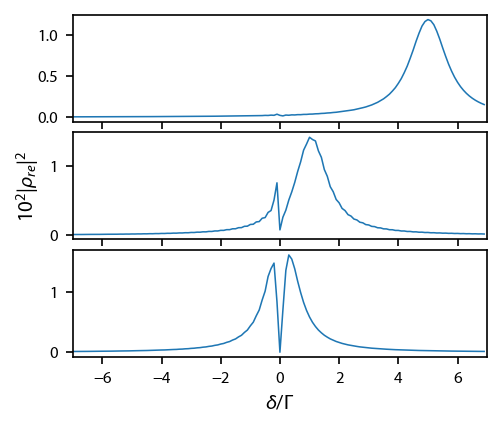

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(3.25, 2.75))
    
for ii, row in enumerate(it.operands[2].T):
    ax[ii].plot(deltas, 1e2*row**2, linewidth=0.75)
    ax[ii].set_xlim(-7, 7)
    if ii<2:
        ax[ii].xaxis.set_ticklabels('')
ax[1].set_ylabel('$10^2|\\rho_{re}|^2$')
ax[-1].set_xlabel('$\delta/\Gamma$')

fig.subplots_adjust(bottom=0.15, left=0.13)